# **Without mask dataframe to MySQL**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

without_mask = pd.read_excel('./마스크 미착용 신고건수.xlsx')
without_mask.rename(columns={"Unnamed: 0": "date", "마스크 미착용 신고건수": "reports_num"}, inplace=True)

print(without_mask.info())
display(without_mask)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         105 non-null    object
 1   reports_num  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None


,date,reports_num
0,2020-09-01,0
1,2020-09-02,0
2,2020-09-03,32
3,2020-09-04,143
4,2020-09-05,118
...,...,...
100,2020-12-10,259
101,2020-12-11,255
102,2020-12-12,283
103,2020-12-13,229


In [13]:
from sqlalchemy import create_engine


# Credentials to database connection
hostname = "kf99database.cu3wxbwt4src.ap-northeast-2.rds.amazonaws.com"
dbname = "kf99"
user = "admin"
pwd = "qjtwlaktmzm"


# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=user, pw=pwd))

# Convert dataframe to sql table                                   
without_mask.to_sql(name='mari_data_1', con=engine, index=False) # 새로 'table' 테이블을 만들어서 알아서 데이터프레임 생성(이미 있으면 불가)

# *Daily Update*

In [14]:
from selenium import webdriver
import urllib.request
import pandas as pd
import time
import datetime


def insert_dataframe_to_MySQL(without_mask): ##################
    # Credentials to database connection
    hostname = "kf99database.cu3wxbwt4src.ap-northeast-2.rds.amazonaws.com"
    dbname = "kf99"
    user = "admin"
    pwd = "qjtwlaktmzm"


    # Create SQLAlchemy engine to connect to MySQL Database
    engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=user, pw=pwd))

    # Convert dataframe to sql table                                   
    without_mask.to_sql(name='mari_data_1', con=engine, index=False, if_exists='append')

    return None

def update_daily_corona_without_mask():
    now = datetime.datetime.now() # 2020-12-14 20:59:02.913798
    #today = now.strftime('%Y-%m-%d') # 2020-12-14 (str)
    oneday = datetime.timedelta(days=1)
    yesterday = (now - oneday).strftime('%Y-%m-%d') # 2020-12-13 (str)
    
    ##### collect the corona data using OpenAPI #####
    ##  AWS에서 실행할 경우  ##
#     chrome_options = webdriver.ChromeOptions()
#     chrome_options.add_argument('--headless')
#     chrome_options.add_argument('--no-sandbox')
#     chrome_options.add_argument('--disable-dev-shm-usage')

#     driver = webdriver.Chrome('/home/lab01/chromedriver', options=chrome_options)
#     driver.implicitly_wait(3)
#     driver.get("https://www.safetyreport.go.kr/#introduction/safeSingoStatistics")

    ##  local에서 실행할 경우  ##
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome('/Users/LimSH/Downloads/chromedriver_win32/chromedriver.exe', chrome_options=options)
    driver.implicitly_wait(3)
    driver.get("https://www.safetyreport.go.kr/#introduction/safeSingoStatistics")

    target = driver.find_element_by_css_selector('#seachDateType')
    target.click()
    category = driver.find_element_by_css_selector('#seachDateType > option:nth-child(2)')
    category.click()
    time.sleep(2)

    start_date_element = driver.find_element_by_css_selector('#C_FRM_DATE')
    start_date_element.clear()
    start_date_element.send_keys(yesterday)
    time.sleep(1)
    end_date_element = driver.find_element_by_css_selector('#C_TO_DATE')
    end_date_element.clear()
    end_date_element.send_keys(yesterday)
    time.sleep(1)
    search_element = driver.find_element_by_css_selector('#form > fieldset > div > button')
    search_element.click()
    time.sleep(1)

    num = driver.find_element_by_css_selector('#grid > tbody > tr:nth-child(23) > td:nth-child(2) > a')
    #print(yesterday, ':', num.text)

    
    without_mask_add = pd.DataFrame({'date': [], 'reports_num': []})
    without_mask_add.loc[len(without_mask_add.index)] = [yesterday, int(num.text)]
    
    insert_dataframe_to_MySQL(without_mask_add)
        
    return None


update_daily_corona_without_mask()

C:\Users\LimSH\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: use options instead of chrome_options


# **Without mask dataframe from MySQL**

In [42]:
import pymysql
conn = pymysql.connect(host='kf99database.cu3wxbwt4src.ap-northeast-2.rds.amazonaws.com',
                       port=3306,
                       user='admin',
                       passwd='qjtwlaktmzm',
                       db='kf99')
try:
    cur = conn.cursor()
    print(type(cur))
    print("----------------------------------------------")
    sql = 'SELECT * FROM mari_data_1'
    cur.execute(sql)
    result = cur.fetchall()
    
    without_mask = pd.DataFrame(result)
    without_mask.rename(columns={0:"", 1: "마스크 미착용 신고건수"}, inplace=True)
    without_mask.set_index("", inplace=True)
    
    display(without_mask)
finally:
    conn.close() # 연결 끊기


<class 'pymysql.cursors.Cursor'>
----------------------------------------------


,마스크 미착용 신고건수
,
2020-09-01,0
2020-09-02,0
2020-09-03,32
2020-09-04,143
2020-09-05,118
...,...
2020-12-11,255
2020-12-12,283
2020-12-13,229


## *update 20.12.15*

In [43]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

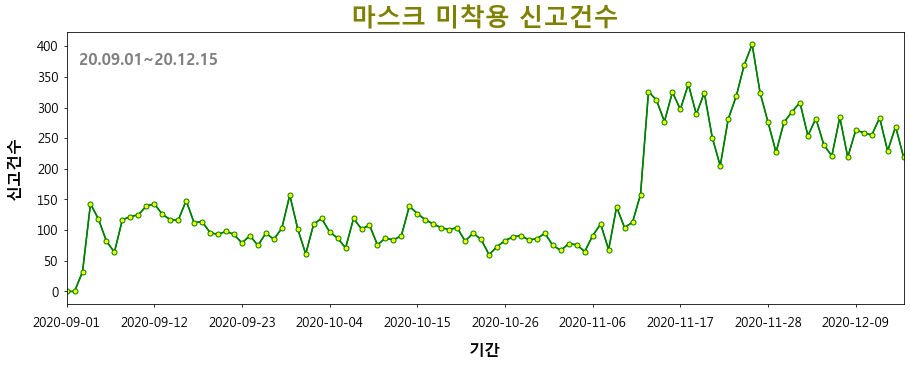

In [45]:
from matplotlib import rcParams

plt.figure(figsize=(15,5))
plt.plot(without_mask.index, without_mask.values, color='green')
plt.plot(without_mask.index, without_mask.values, marker='o', markersize=5, color='green', markerfacecolor='yellow')

plt.title('마스크 미착용 신고건수', size=25, color='olive', fontweight='bold')
plt.xticks(without_mask.index, size=13)
plt.yticks(size=13) 
plt.xlabel('기간', size=16, fontweight='bold', labelpad=13)
plt.ylabel('신고건수', size=16, fontweight='bold', labelpad=13)
plt.locator_params(axis='x', nbins=10)
plt.tick_params(axis='x', direction='out', length=3, pad=10, bottom=True)
plt.tick_params(axis='y', direction='out', length=3, pad=5, left=True)
plt.annotate("20.09.01~20.12.15", (1.5,370), size=16, color='gray', fontweight='bold')
plt.xlim(without_mask.index[0], without_mask.index[-1])

plt.savefig('./마스크 미착용 신고건수(10월1일~12월15일).png', bbox_inches = 'tight')
plt.show()